In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
import shap
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Path to directory containing the final CSV files
base_path = "C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/Merged/"

In [7]:
# File names
sc_file = "sc_cleaned_combined_2013_2022.csv"
tn_file = "TN_PROCESSED.csv"
pa_file = "PA_PROCESSED.csv"

In [8]:
# LOAD FILES FLEXIBLY
def load_if_exists(filepath):
    if os.path.exists(filepath):
        return pd.read_csv(filepath, dtype=str)
    else:
        print(f"File not found: {filepath}. Skipping...")
        return None

sc_df = load_if_exists(os.path.join(base_path, sc_file))
tn_df = load_if_exists(os.path.join(base_path, tn_file))
pa_df = load_if_exists(os.path.join(base_path, pa_file))

dfs = [df for df in [sc_df, tn_df, pa_df] if df is not None]

if len(dfs) == 0:
    raise ValueError("No datasets found to merge.")

# Merge datasets
merged_df = pd.concat(dfs, ignore_index=True)

File not found: C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/SC/tn_cleaned_combined_2013_2022.csv. Skipping...
File not found: C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/SC/pa_cleaned_combined_2013_2022.csv. Skipping...


In [9]:
# DATA PREP
# Convert important fields
merged_df["crash_date"] = pd.to_datetime(merged_df["crash_date"], errors="coerce")
merged_df["severity_level"] = pd.to_numeric(merged_df["severity_level"], errors="coerce")
merged_df["driver_age"] = pd.to_numeric(merged_df["driver_age"], errors="coerce")
merged_df["opioid_flag"] = pd.to_numeric(merged_df["opioid_flag"], errors="coerce")
merged_df["alcohol_flag"] = pd.to_numeric(merged_df["alcohol_flag"], errors="coerce")
merged_df["any_drug_flag"] = pd.to_numeric(merged_df["any_drug_flag"], errors="coerce")

print(f"Merged dataset shape: {merged_df.shape}")
print(f"Year range: {merged_df['crash_date'].dt.year.min()} → {merged_df['crash_date'].dt.year.max()}")

Merged dataset shape: (2526020, 14)
Year range: 2013 → 2022


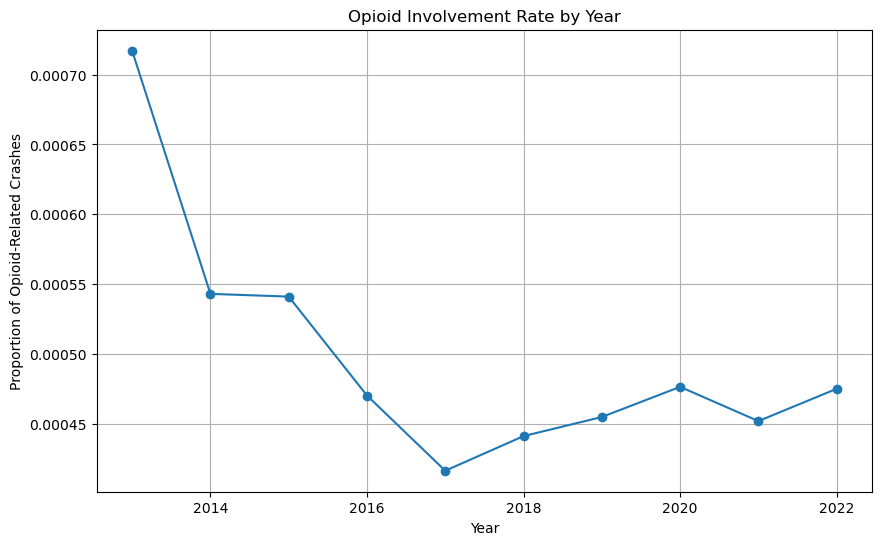

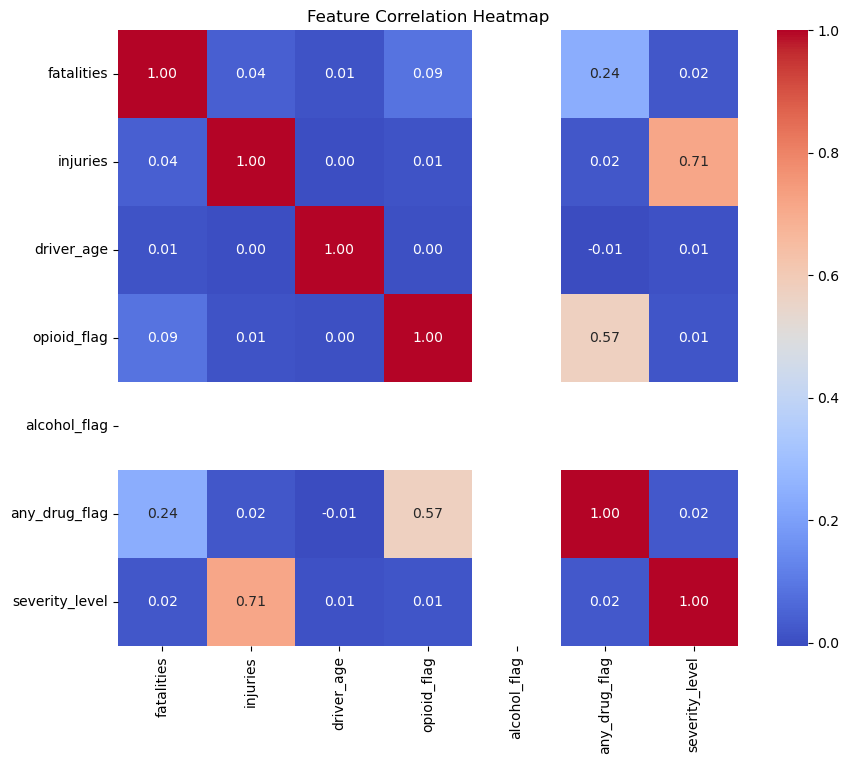

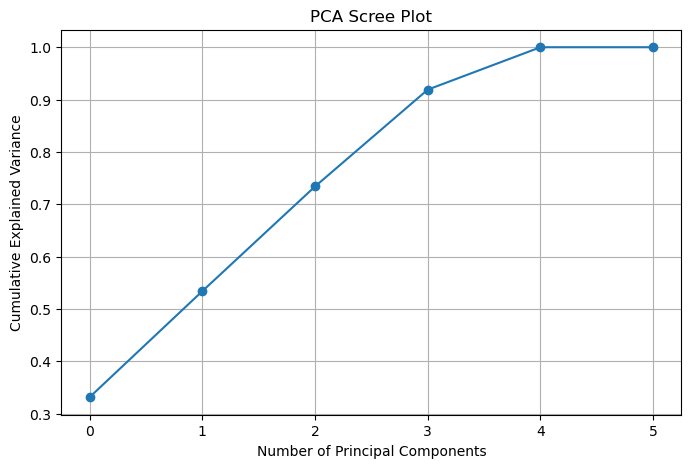

In [10]:
# EDA (Exploratory Data Analysis)

# 1. Temporal Trend: Opioid involvement by year
plt.figure(figsize=(10,6))
merged_df.groupby(merged_df['crash_date'].dt.year)["opioid_flag"].mean().plot(marker='o')
plt.title("Opioid Involvement Rate by Year")
plt.ylabel("Proportion of Opioid-Related Crashes")
plt.xlabel("Year")
plt.grid()
plt.show()

# 2. Correlation heatmap
plt.figure(figsize=(10,8))
corr = merged_df[['fatalities', 'injuries', 'driver_age', 'opioid_flag', 'alcohol_flag', 'any_drug_flag', 'severity_level']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# 3. PCA Scree plot
features = ['driver_age', 'opioid_flag', 'alcohol_flag', 'any_drug_flag', 'fatalities', 'injuries']
X_scaled = StandardScaler().fit_transform(merged_df[features].fillna(0))
pca = PCA()
pca.fit(X_scaled)
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.grid()
plt.show()

In [11]:
# TIME SERIES SPLIT
merged_df = merged_df.sort_values('crash_date')
train_df = merged_df[(merged_df['crash_date'].dt.year >= 2013) & (merged_df['crash_date'].dt.year <= 2020)]
valid_df = merged_df[(merged_df['crash_date'].dt.year == 2021)]
test_df  = merged_df[(merged_df['crash_date'].dt.year == 2022)]

print(f"Train size: {train_df.shape[0]}, Valid size: {valid_df.shape[0]}, Test size: {test_df.shape[0]}")

Train size: 1984273, Valid size: 274401, Test size: 267346


In [12]:
# BASELINE LOGISTIC REGRESSION
# Target: Opioid Involvement Prediction
baseline_model = LogisticRegression(max_iter=1000)
X_train = train_df[['driver_age', 'alcohol_flag', 'any_drug_flag']]
y_train = train_df['opioid_flag']
baseline_model.fit(X_train, y_train)

X_test = test_df[['driver_age', 'alcohol_flag', 'any_drug_flag']]
y_test = test_df['opioid_flag']
y_pred = baseline_model.predict(X_test)

print("=== Logistic Regression Performance ===")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, baseline_model.predict_proba(X_test)[:,1]))

=== Logistic Regression Performance ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    267219
           1       0.38      0.29      0.33       127

    accuracy                           1.00    267346
   macro avg       0.69      0.65      0.67    267346
weighted avg       1.00      1.00      1.00    267346

ROC-AUC: 0.9995206827464912


In [13]:
# BOOTSTRAPPED RANDOM FOREST ENSEMBLE
ensemble_preds = []
for i in range(30):
    sample = train_df.sample(frac=1.0, replace=True)
    X_sample = sample[['driver_age', 'alcohol_flag', 'any_drug_flag']]
    y_sample = sample['severity_level']
    rf = RandomForestClassifier(n_estimators=100, random_state=i)
    rf.fit(X_sample, y_sample)
    ensemble_preds.append(rf.predict(X_test))

ensemble_preds = np.array(ensemble_preds)
ensemble_mean_pred = np.round(ensemble_preds.mean(axis=0))

print("=== Random Forest Ensemble Performance ===")
print(classification_report(test_df['severity_level'], ensemble_mean_pred))

=== Random Forest Ensemble Performance ===
              precision    recall  f1-score   support

           0       0.83      1.00      0.90    220265
           1       0.49      0.17      0.25      1223
           2       0.06      0.00      0.00      2623
           3       0.11      0.00      0.00     12115
           4       0.25      0.00      0.00     31120

    accuracy                           0.82    267346
   macro avg       0.35      0.23      0.23    267346
weighted avg       0.72      0.82      0.75    267346



In [14]:
# XGBOOST WITH GRIDSEARCH
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}
grid = GridSearchCV(xgb, param_grid, cv=3, scoring='f1_weighted')
grid.fit(X_train, train_df['severity_level'])

best_xgb = grid.best_estimator_
xgb_preds = best_xgb.predict(X_test)

print("=== XGBoost Performance ===")
print(classification_report(test_df['severity_level'], xgb_preds))

=== XGBoost Performance ===
              precision    recall  f1-score   support

           0       0.83      1.00      0.90    220265
           1       0.54      0.18      0.27      1223
           2       0.00      0.00      0.00      2623
           3       0.18      0.00      0.00     12115
           4       0.32      0.00      0.00     31120

    accuracy                           0.82    267346
   macro avg       0.37      0.24      0.24    267346
weighted avg       0.73      0.82      0.75    267346



Shape of shap_values: (267346, 3, 5)
Shape of X_test: (267346, 3)

Plotting SHAP summary for Severity Class 0


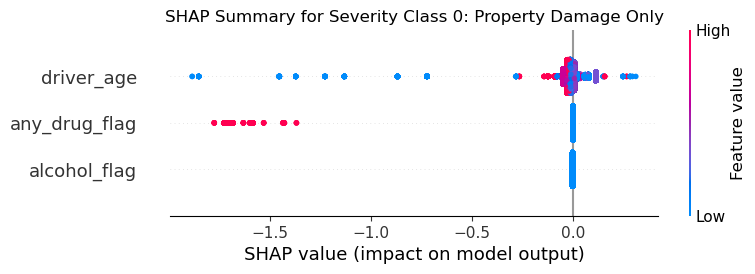


Plotting SHAP summary for Severity Class 1


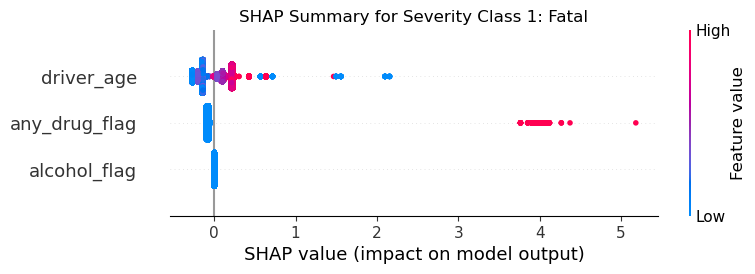


Plotting SHAP summary for Severity Class 2


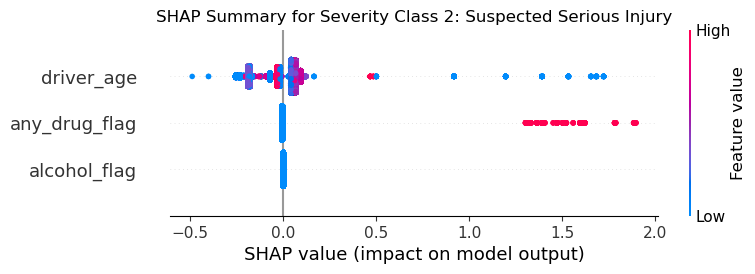


Plotting SHAP summary for Severity Class 3


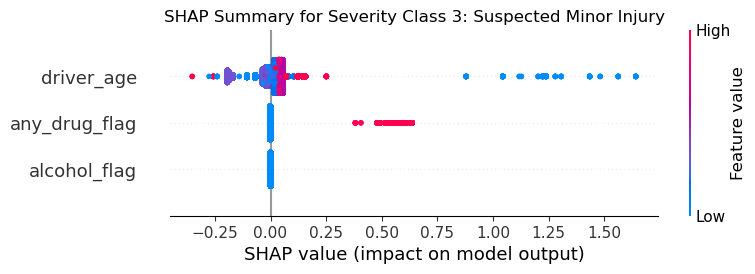


Plotting SHAP summary for Severity Class 4


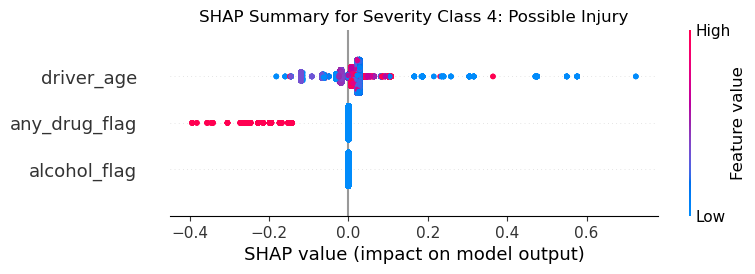


Plotting SHAP summary for Severity Class 8


IndexError: index 8 is out of bounds for axis 2 with size 5

In [20]:
# SHAP VALUES for Interpretability
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test) # This is a (samples, features, classes) numpy array

# Verify the shape
print(f"Shape of shap_values: {shap_values.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Plot for class 0: Property Damage Only
print("\nPlotting SHAP summary for Severity Class 0")
shap.summary_plot(shap_values[:, :, 0], X_test, show=False)
plt.title("SHAP Summary for Severity Class 0: Property Damage Only")
plt.show()

# Plot for class 1: Fatal
print("\nPlotting SHAP summary for Severity Class 1")
shap.summary_plot(shap_values[:, :, 1], X_test, show=False)
plt.title("SHAP Summary for Severity Class 1: Fatal")
plt.show()

# Plot for class 2: Suspected Serious Injury
print("\nPlotting SHAP summary for Severity Class 2")
shap.summary_plot(shap_values[:, :, 2], X_test, show=False)
plt.title("SHAP Summary for Severity Class 2: Suspected Serious Injury")
plt.show()

# Plot for class 3: Suspected Minor Injury
print("\nPlotting SHAP summary for Severity Class 3")
shap.summary_plot(shap_values[:, :, 3], X_test, show=False)
plt.title("SHAP Summary for Severity Class 3: Suspected Minor Injury")
plt.show()

# Plot for class 4: Possible Injury
print("\nPlotting SHAP summary for Severity Class 4")
shap.summary_plot(shap_values[:, :, 4], X_test, show=False)
plt.title("SHAP Summary for Severity Class 4: Possible Injury")
plt.show()

# Plot for class 8: Injury – Unknown Severity
print("\nPlotting SHAP summary for Severity Class 8")
shap.summary_plot(shap_values[:, :, 8], X_test, show=False)
plt.title("SHAP Summary for Severity Class 8: Injury – Unknown Severity")
plt.show()

# Plot for class 9: Injury – Unknown Severity
print("\nPlotting SHAP summary for Severity Class 9")
shap.summary_plot(shap_values[:, :, 9], X_test, show=False)
plt.title("SHAP Summary for Severity Class 9: Unknown if Injured")
plt.show()

In [19]:
# CB-SEM and PLS-SEM PLACEHOLDER ---
# Requires a separate notebook running an R kernel

# Will need to merge the final datasets first, example:
# merged_df.to_csv("merged_dataset_ready_for_sem.csv", index=False)